In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats
from tqdm import tqdm
import sys
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [32]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (8, 4)
np.random.seed(50340488)

C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\4067300880.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# q1

In [27]:
stats.norm.cdf(65, 50, 20) - stats.norm.cdf(55, 50, 20)

0.17466632194020804

In [33]:
data = pd.DataFrame(np.random.normal(50, 20, 120))
data.mean(), data.std() / np.sqrt(120)

(0    49.368831
 dtype: float64,
 0    1.911499
 dtype: float64)

# q2

In [34]:
df = pd.DataFrame({'g':[5.50, 5.61, 4.88, 5.07, 5.26], 'err':[0.10, 0.21, 0.15, 0.14, 0.13]})
df

,g,err
0,5.50,0.10
1,5.61,0.21
2,4.88,0.15
3,5.07,0.14
4,5.26,0.13


In [44]:
def weighted_mean(y, y_err):
    numerator = 0
    denominator = 0
    for gval, errval in zip(y, y_err):
        numerator += gval / errval**2
        denominator += 1 / errval**2
    mean = numerator / denominator
    err = np.sqrt(1 / denominator)
    return mean, err

weighted_mean(df['g'], df['err'])

(5.279305828390056, 0.06005034708204228)

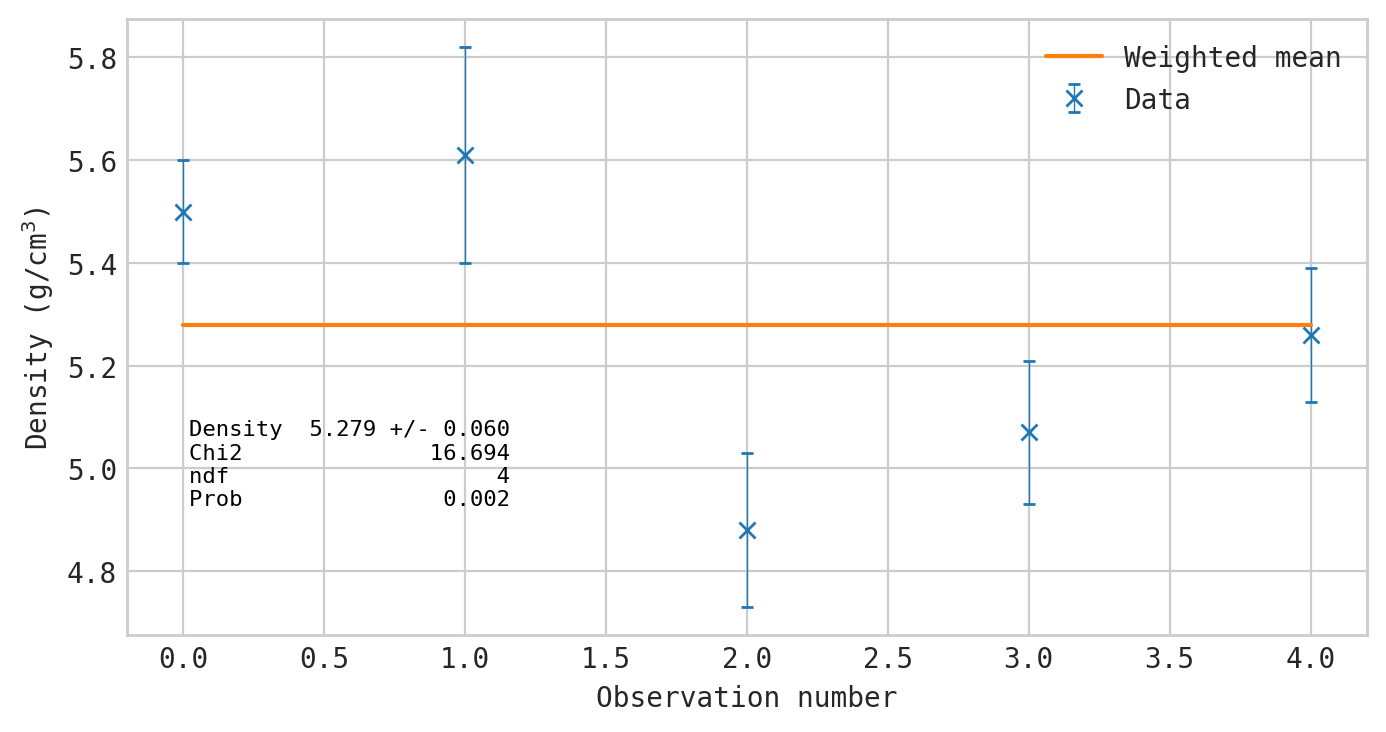

In [60]:
# Now we define a ChiSquare to be minimised (using ExternalFunctions):
chi2_object = Chi2Regression(lambda x,c: c, df.index, df['g'], df['err'])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_object, c=np.average(df['g']))     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 1                   # Number of variables (a, b, c, d)
Ndof_fit = len(df) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.errorbar(df.index, df['g'], df['err'], label='Data', capsize=2, elinewidth=0.5, fmt='x ')
x = np.linspace(min(df.index), max(df.index), 100)
plt.plot(x, minuit.values['c']*x**0, label=f'Weighted mean')
plt.xlabel('Observation number')
plt.ylabel(r'Density (g/cm$^3$)')
plt.legend()

d = {
     'Density': [minuit.values['c'], minuit.errors['c']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.35, text, ax, fontsize=8)


# q3

In [65]:
def safe_root(f, df, a, b, tolerance=1e-13, max_iterations=1000):
    '''
    Uses a root finding algorithm that guarantees convergence every time step.

    The function attempts a newton stop every iteration, and if the approximate root
    lies outside the interval, it uses a bisection step again. The interval is
    constricted at the end of every step. 

    Args: 
        f (function): A function with a single (float) input
        df (function): The derivative of the function, again with a single (float) input
        a (float): The lower end of the initial interval. Used as the initial Newton seed
        b (float): The upper end of the interval. Note that f(a)*f(b) should be negative
        tolerance (float): The tolerance at which the algorithm stops iterating
        max_iterations (int): The maximum iterations after which the algorithm ends

    Returns:
        x (float): The approximate root of the function, correct to `tolerance`
        n_calls (int): The number of function calls used by the algorithm
    '''
    f_a = f(a)
    x = a
    f_x = f_a
    n_calls = 1
    for i in range(max_iterations):
        newton_x = x - (f_x / df(x))  # attempt newton step
        n_calls += 1
        if (a < newton_x < b):
            x = newton_x
        else:
            x = a + (b-a) / 2  # bisection step
        f_x = f(x)
        n_calls += 1
        if f_a * f_x > 0:
            a, f_a = x, f_x
        else:
            b = x
        if np.abs(f_x) < tolerance: break
    return x, n_calls

def CDF(x, sigma=2):
    return 1 - np.exp(-x**2 / (2*sigma**2))

def PDF(x, sigma=2):
    return (x/sigma**2) * np.exp(-x**2 / (2*sigma**2))

def inv_CDF(x):
    result = np.zeros_like(x)
    for i, xval in enumerate(x):
        root = safe_root(lambda l: CDF(l) - xval, PDF, 0, 1e10, 1e-6)[0]
        result[i] = root
    return result

def inverse_transform_sample(inverse_CDF, n_samples):
    r = np.random.rand(n_samples)
    return inverse_CDF(r)

C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\1498325857.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  newton_x = x - (f_x / df(x))  # attempt newton step


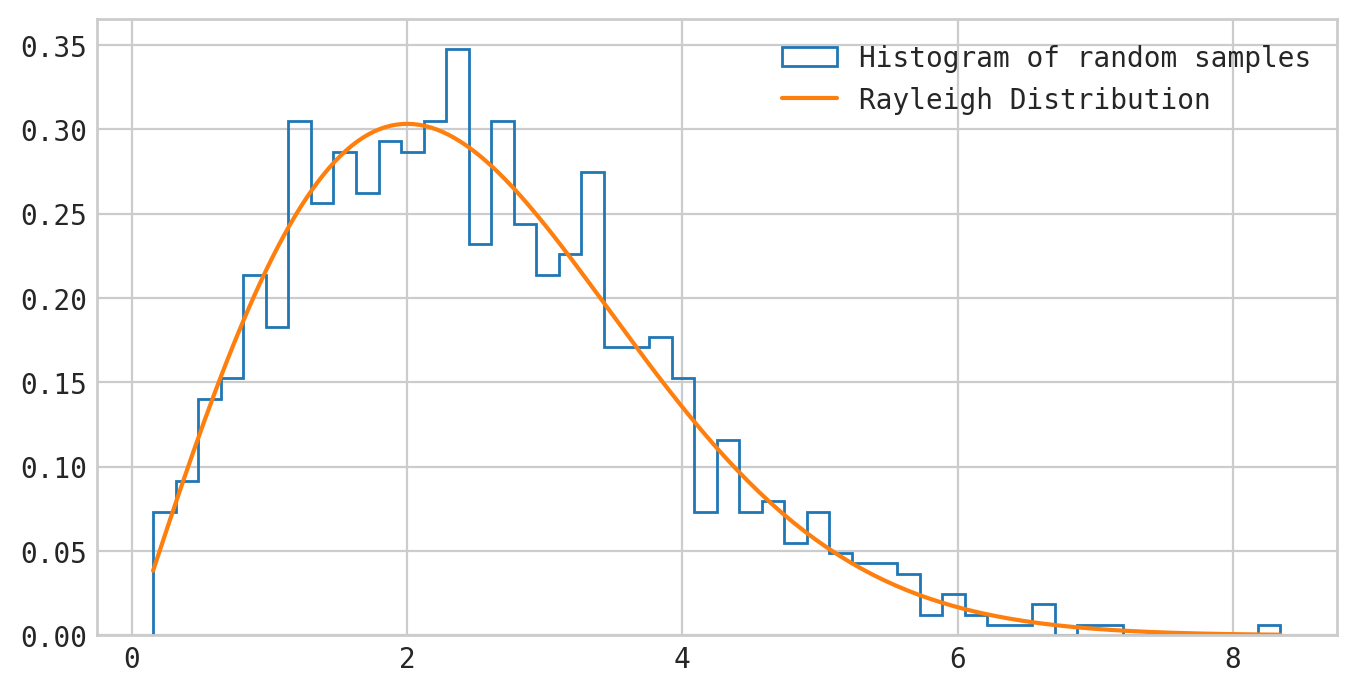

In [86]:
samples = inverse_transform_sample(inv_CDF, 1000)
domain = np.linspace(samples.min(), samples.max(), 200)

plt.hist(samples, bins=50, density=True, label='Histogram of random samples', histtype='step')
plt.plot(domain, PDF(domain), label='Rayleigh Distribution')
plt.legend();

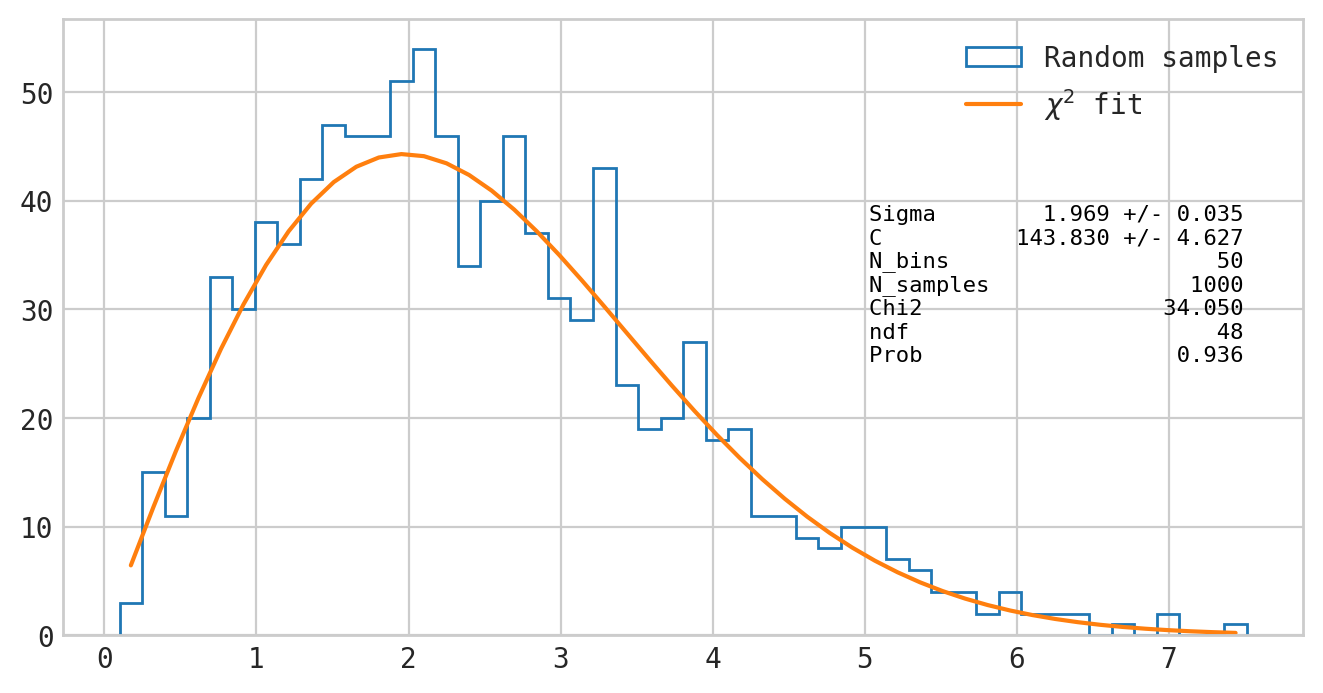

In [85]:
def fit_sigma(x, sigma, C):
    return C*(x/sigma**2) * np.exp(-x**2 / (2*sigma**2))

Nbins = 50

y, x_edges = np.histogram(samples, bins=Nbins)

x = (x_edges[1:] + x_edges[:-1])/2

chi2_object = Chi2Regression(fit_sigma, x[y>0], y[y>0], np.sqrt(y)[y>0])
chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_object, sigma=2, C=200)     # External Functions

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables (sigma, C)
Ndof_fit = Nbins - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

fig, ax = plt.subplots()
plt.hist(samples, bins=Nbins, histtype='step', label='Random samples')
plt.plot(x, fit_sigma(x, minuit.values['sigma'], minuit.values['C']), label=r'$\chi^2$ fit')
plt.legend()

d = {'Sigma': [minuit.values['sigma'], minuit.errors['sigma']],
     'C': [minuit.values['C'], minuit.errors['C']],
     'N_bins' : Nbins,
     'N_samples' : 1000,
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text, ax, fontsize=8)


In [109]:
def get_sigma_uncertainity(N_samples):

    samples = inverse_transform_sample(inv_CDF, N_samples)

    Nbins = max(10, int(N_samples/20))

    y, x_edges = np.histogram(samples, bins=Nbins)

    x = (x_edges[1:] + x_edges[:-1])/2

    chi2_object = Chi2Regression(fit_sigma, x[y>0], y[y>0], np.sqrt(y)[y>0])
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    minuit = Minuit(chi2_object, sigma=2, C=200)     # External Functions

    # Perform the actual fit:
    minuit.migrad()

    return minuit.errors['sigma']


In [125]:
N_sample_data = np.geomspace(50, 5000, 100)
sigma_err_data = []
for N_samples in tqdm(N_sample_data):
    sigma_err_data.append(get_sigma_uncertainity(int(N_samples)))

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\rizfn\AppData\Local\Temp\ipykernel_22612\1498325857.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  newton_x = x - (f_x / df(x))  # attempt newton step
100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


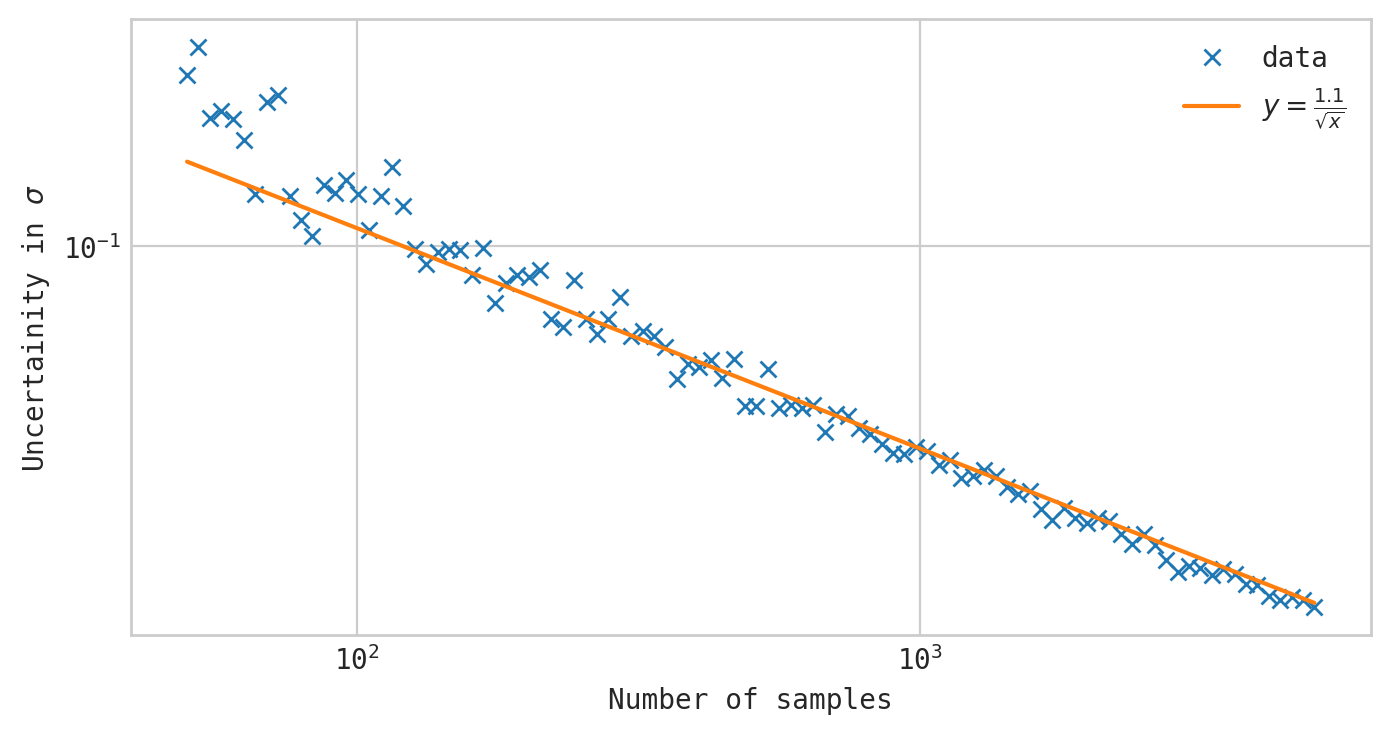

In [140]:
plt.plot(N_sample_data, sigma_err_data, marker='x', linestyle='', label='data')
plt.plot(N_sample_data, 1.1/np.sqrt(N_sample_data), label=r'$y=\frac{1.1}{\sqrt{x}}$')
plt.ylabel(r'Uncertainity in $\sigma$')
plt.xlabel('Number of samples')
plt.yscale('log')
plt.xscale('log')
plt.legend()

# q4

## 4.1

In [148]:
df = pd.read_csv('data_AnorocDisease.csv')
df = df.rename(columns={'  Temp':'Temp','   BloodP':'BloodP', '   Age':'Age', '      Status (0: Healthy; 1: Ill; -1: Unknown)':'Status'})
df

,PatientID,Temp,BloodP,Age,Status
0,1.0,36.3,125.7,56.8,0.0
1,2.0,37.6,121.4,67.7,1.0
2,3.0,38.7,117.6,67.3,1.0
3,4.0,35.8,116.3,60.0,0.0
4,5.0,37.6,142.9,81.9,0.0
...,...,...,...,...,...
995,996.0,37.1,127.6,74.2,-1.0
996,997.0,36.9,123.7,47.1,-1.0
997,998.0,37.3,113.4,39.2,-1.0
998,999.0,37.0,129.3,68.3,-1.0


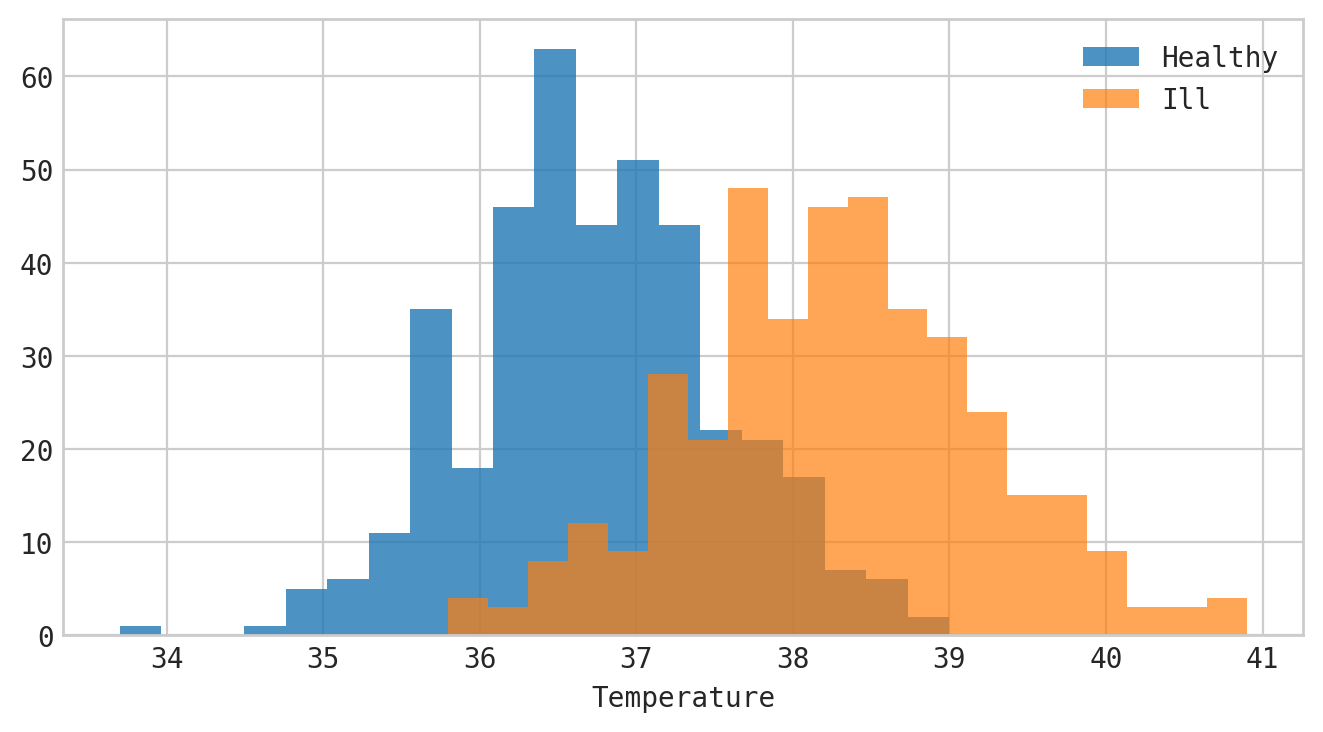

In [162]:
plt.hist(df[df['Status']==0]['Temp'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['Temp'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Temperature')
plt.legend()

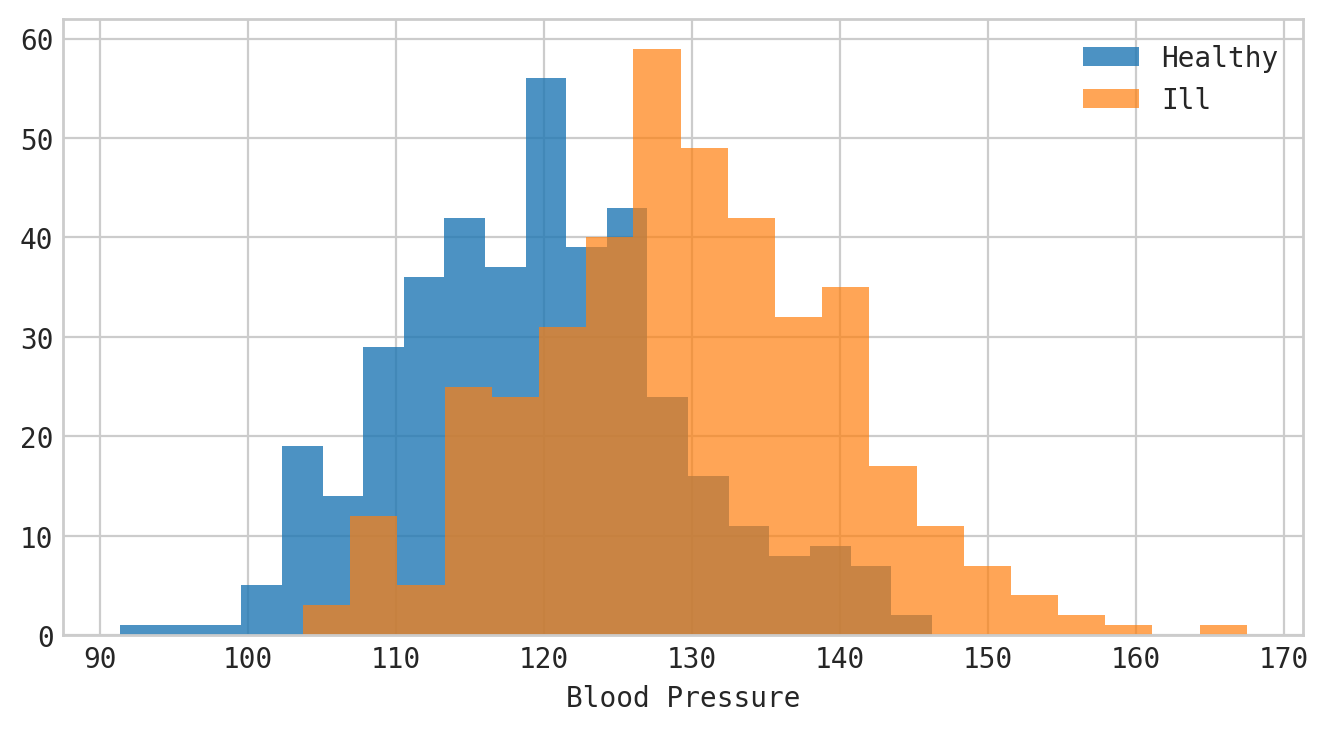

In [163]:
plt.hist(df[df['Status']==0]['BloodP'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['BloodP'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Blood Pressure')
plt.legend()

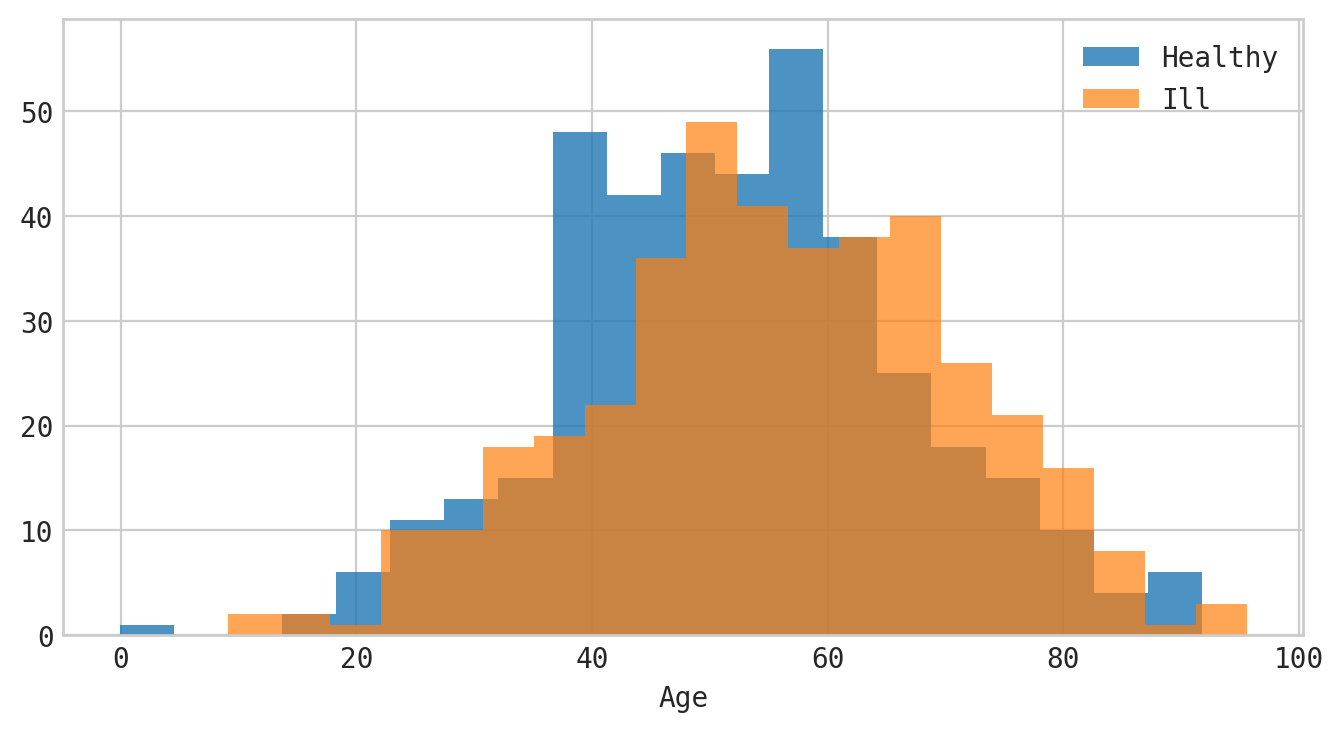

In [166]:
plt.hist(df[df['Status']==0]['Age'], histtype='stepfilled', label='Healthy', bins=20, alpha=0.8)
plt.hist(df[df['Status']==1]['Age'], histtype='stepfilled', label='Ill', bins=20, alpha=0.7)
plt.xlabel('Age')
plt.legend()

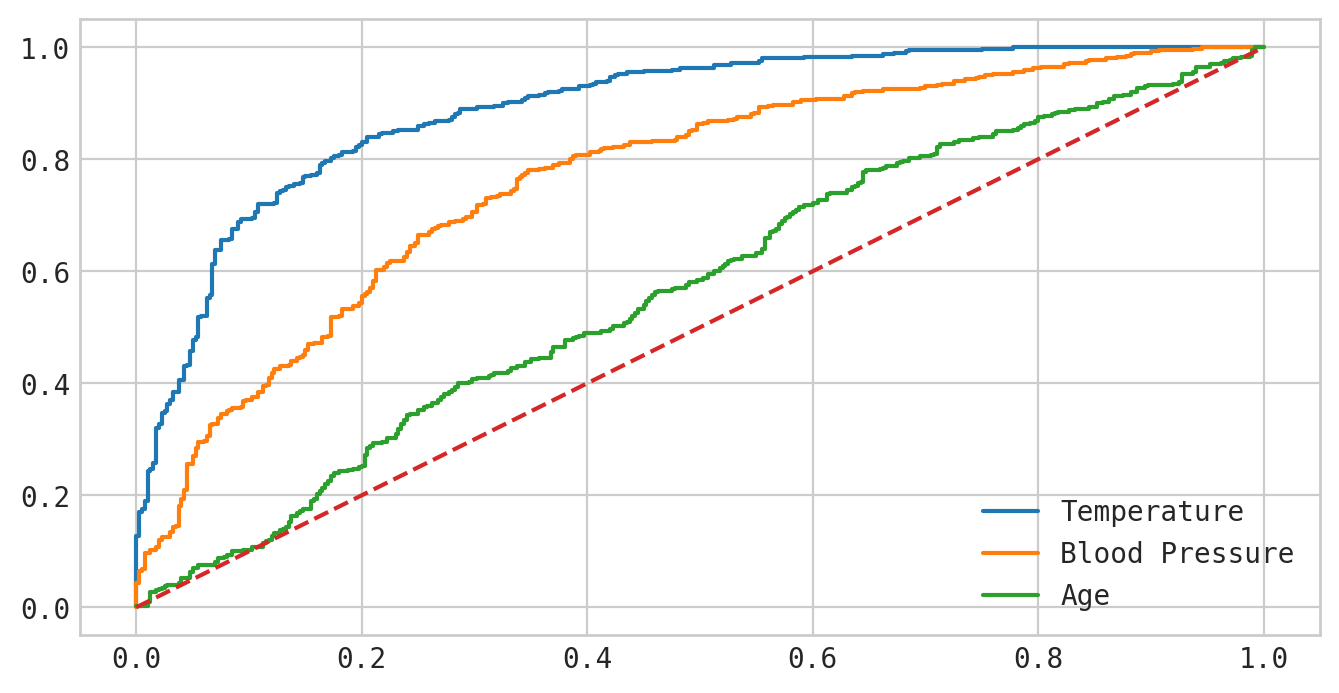

In [181]:
def generate_ROC_data(statistic):
    sorted_df = df.sort_values(by=statistic)
    healthy = sorted_df['Status'] == 0
    ill = sorted_df['Status'] == 1
    cdf1 = ill.cumsum()
    cdf1 /= np.max(cdf1)
    cdf2 = healthy.cumsum()
    cdf2 /= np.max(cdf2)
    return cdf1, cdf2

x, y = generate_ROC_data('Temp')
plt.plot(x, y, label='Temperature')
x, y = generate_ROC_data('BloodP')
plt.plot(x, y, label='Blood Pressure')
x, y = generate_ROC_data('Age')
plt.plot(x, y, label='Age')
plt.plot([0,1], [0,1], linestyle='--')
plt.legend()

## 4.2

In [144]:
df = pd.read_csv('data_CountryScores.csv')
df

,Country,GDP,PopSize,Happiness-index,EconomicFreedom-index,PressFreedom-index,Education-index
0,Afghanistan,592.0,18356000.0,2523.0,53.0,40.19,0.414
1,Albania,5837.0,2187000.0,5117.0,65.2,30.59,0.746
2,Algeria,3638.0,27620000.0,4887.0,49.7,47.26,0.672
3,Argentina,9929.0,30799000.0,5929.0,52.7,28.99,0.855
4,Armenia,4595.0,2176000.0,5283.0,71.9,28.83,0.740
...,...,...,...,...,...,...,...
128,Uruguay,16965.0,2530000.0,6431.0,69.3,16.38,0.765
129,Venezuela,1627.0,18359000.0,4892.0,24.7,47.60,0.700
130,Vietnam,3743.0,68565000.0,5411.0,61.7,78.46,0.630
131,Zambia,1115.0,8331000.0,4073.0,50.4,38.21,0.557


# q5